In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.hr.stop_words import STOP_WORDS
import classla
from wordcloud import WordCloud

from PIL import Image
import matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
#Load transcription.
with open(f"transcription.txt","r") as f:
    content=f.read()

In [3]:
#Prepping stopwords loaded from Spacy.
stopwords=set(STOP_WORDS)
#Creating pipeline for POS tagging and lemmatization.
nlp=classla.Pipeline("hr", processors="tokenize,pos,lemma")

2022-08-05 02:58:57 INFO: Loading these models for language: hr (Croatian):
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |

2022-08-05 02:58:57 INFO: Use device: cpu
2022-08-05 02:58:57 INFO: Loading: tokenize
2022-08-05 02:58:57 INFO: Loading: pos
2022-08-05 02:58:58 INFO: Loading: lemma
2022-08-05 02:59:04 INFO: Done loading processors!


In [4]:
#Create lemmatized transcription.
tokens_lemmatized=[t["lemma"] for t in nlp(content).to_dict()[0][0]]
content_lemmatized=" ".join(tokens_lemmatized)

In [5]:
def top_most_n_features(text: str, n: int) -> pd.DataFrame:
    vectorizer=TfidfVectorizer()
    response=vectorizer.fit_transform([text])
    feature_array=np.array(vectorizer.get_feature_names_out())
    tfidf_sorting=np.argsort(response.toarray()).flatten()[::-1]
    names=feature_array[tfidf_sorting][:n]
    tf_idfs=response/vectorizer.idf_
    frequencies=np.array(tf_idfs.tolist()[0])[tfidf_sorting][:n]
    return pd.DataFrame({"name":names,"frequency":frequencies},columns=["name", "frequency"])

def top_least_n_features(text: str, n: int) -> pd.DataFrame:
    vectorizer=TfidfVectorizer()
    response=vectorizer.fit_transform([text])
    feature_array=np.array(vectorizer.get_feature_names_out())
    tfidf_sorting=np.argsort(response.toarray()).flatten()[::-1]
    names=feature_array[tfidf_sorting][-n:]
    tf_idfs=response/vectorizer.idf_
    frequencies=np.array(tf_idfs.tolist()[0])[tfidf_sorting][-n:]
    return pd.DataFrame({"name":names,"frequency":frequencies},columns=["name", "frequency"])

In [6]:
top_most_n_features(content_lemmatized,20).head()

,name,frequency
0,biti,0.666902
1,za,0.284785
2,da,0.230712
3,na,0.227107
4,sebe,0.201873


In [22]:
def gradient(color1_hex: str,color2_hex: str, mix_portion: int=0) -> str:
    color1_rgb=np.array(matplotlib.colors.to_rgb(color1_hex))
    color2_rgb=np.array(matplotlib.colors.to_rgb(color2_hex))
    return matplotlib.colors.to_hex((1-mix_portion)*color1_rgb + mix_portion*color2_rgb)

def colors(color1_hex: str, color2_hex: str, referent_max_value: float, frequencies: list) -> list:
    return [gradient(color1_hex,color2_hex,(1-x/referent_max_value)**8) for x in frequencies]

def tf_idf_plot(df: pd.DataFrame, referent_max_value: float) -> None:
    f, ax=plt.subplots(figsize=(20, 13))
    sns.barplot(x="frequency", y="name", data=df, palette=colors("#2abfcc","#a030bf",referent_max_value,df["frequency"]))
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel("TF-IDF", fontsize=25)
    plt.ylabel("Lemma", fontsize=25)
    plt.show()

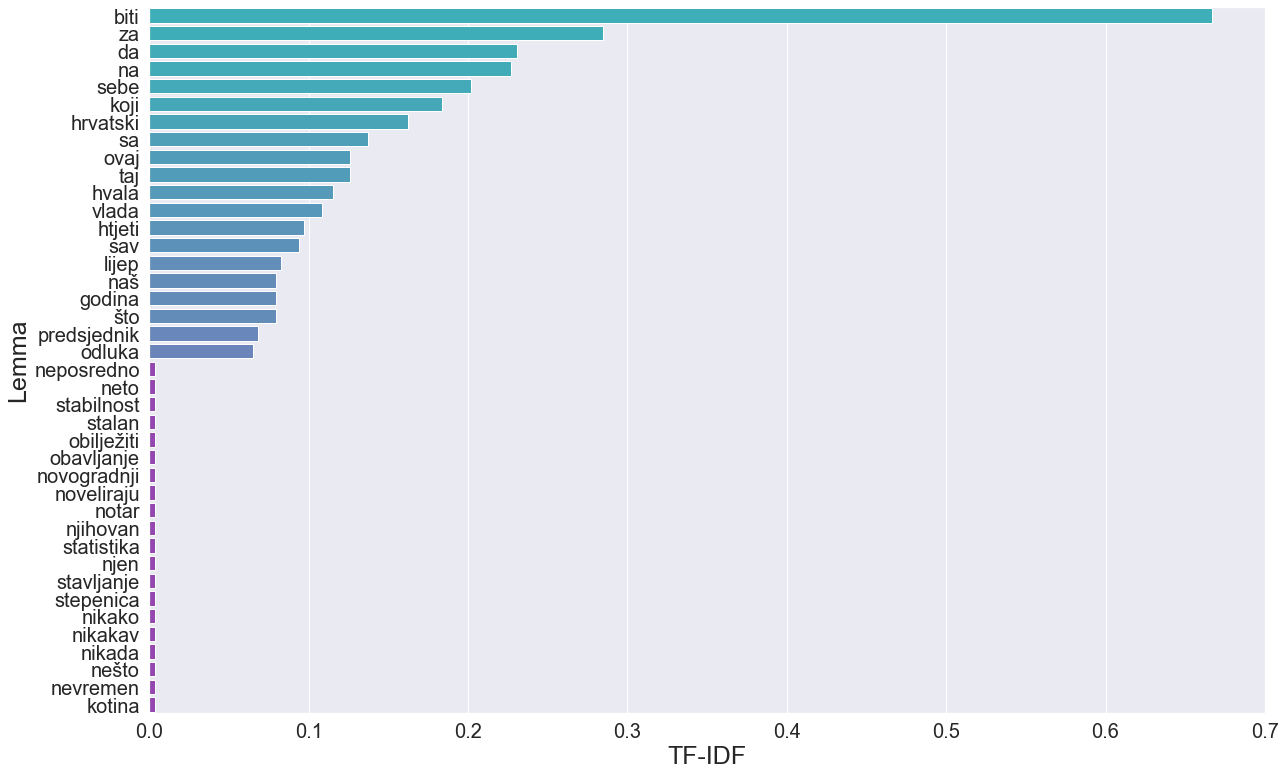

In [23]:
df1=top_most_n_features(content_lemmatized,20)
df2=top_least_n_features(content_lemmatized,20)
referent_max_value=max(df1["frequency"])
tf_idf_plot(pd.concat([df1, df2]),referent_max_value=referent_max_value)

In [16]:
stoplemmas=[t["lemma"] for t in nlp(" ".join(stopwords)).to_dict()[0][0]]

content_stopwords=""
for t in content.split():
    t_nlp=nlp(t).to_dict()[0][0][0]
    if t_nlp["lemma"] not in stoplemmas:
        content_stopwords+=t+" "
content_stopwords=content_stopwords[:-1]

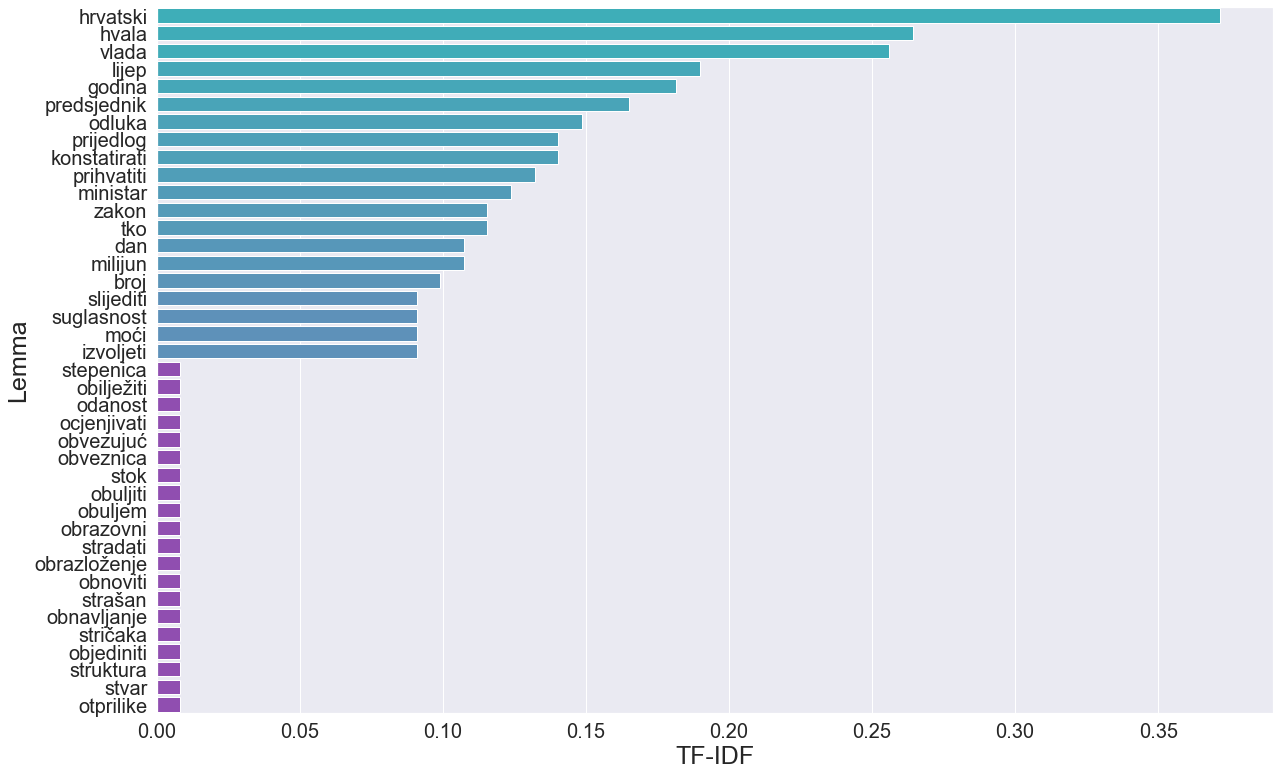

In [24]:
tokens_stopwords_lemmatized=[t["lemma"] for t in nlp(content_stopwords).to_dict()[0][0]]
content_stopwords_lemmatized=" ".join(tokens_stopwords_lemmatized)

df1=top_most_n_features(content_stopwords_lemmatized,20)
df2=top_least_n_features(content_stopwords_lemmatized,20)
tf_idf_plot(pd.concat([df1, df2]),referent_max_value=referent_max_value)

In [25]:
df=top_most_n_features(content_lemmatized,40)

content_filtered=""
for t in content.split():
    t_nlp=nlp(t).to_dict()[0][0][0]
    if t_nlp["lemma"] not in df["name"].to_list():
        if t_nlp["upos"]!="VERB":
            if t not in stopwords:
                content_filtered+=t+" "
content_filtered=content_filtered[:-1]

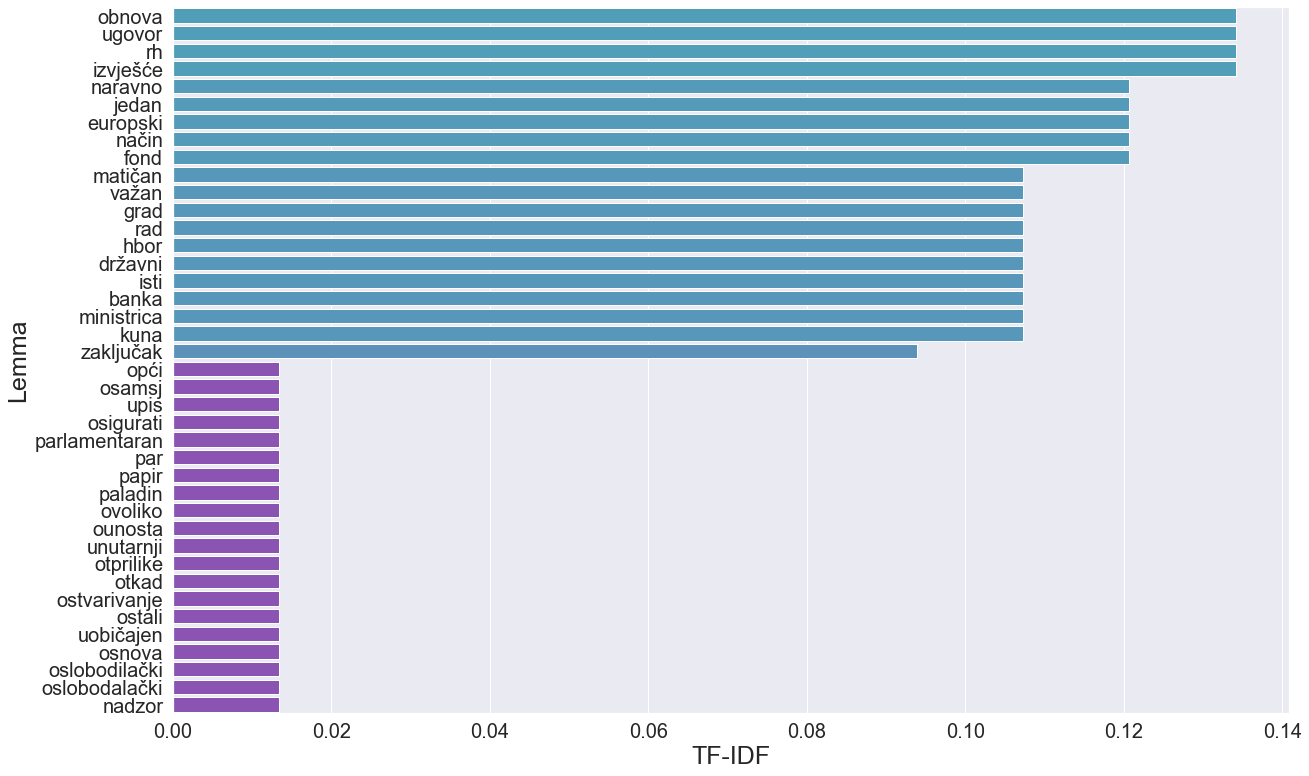

In [26]:
tokens_filtered_lemmatized=[t["lemma"] for t in nlp(content_filtered).to_dict()[0][0]]
content_filtered_lemmatized=" ".join(tokens_filtered_lemmatized)

df1=top_most_n_features(content_filtered_lemmatized,20)
df2=top_least_n_features(content_filtered_lemmatized,20)
tf_idf_plot(pd.concat([df1, df2]),referent_max_value=referent_max_value)

In [27]:
mask=np.array(Image.open(f"data/cloud_mask.png"))

wordcloud=WordCloud(max_words=40, include_numbers=True, min_word_length=0, collocations=True, collocation_threshold=3,
                width=2560, height=1600, background_color="#333f5e", min_font_size=5, mask=mask).generate(content)

wordcloud_stopwords=WordCloud(max_words=40, include_numbers=True, min_word_length=0, collocations=True, collocation_threshold=3,
                width=2560, height=1600, background_color="#333f5e", min_font_size=5, mask=mask,
                stopwords=stopwords).generate(content)

wordcloud_stopwords_filtered=WordCloud(max_words=40, include_numbers=True, min_word_length=0, collocations=True, collocation_threshold=3,
                width=2560, height=1600, background_color="#333f5e", min_font_size=5, mask=mask,
                stopwords=stopwords).generate(content_filtered)

In [28]:
def neos_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None) -> str:
    h=185
    s=66
    l=random_state.randint(40, 100)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def wordcloud_plot(wordcloud: WordCloud) -> None:
    #Plot wordcloud in the shape of a cloud.
    fig, ax=plt.subplots(figsize=(16,10), facecolor=None) #plt.figure(figsize=(16, 10), facecolor=None)
    plt.imshow(wordcloud.recolor(color_func=neos_color_func, random_state=42), interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    #Add Neos logo in the bottom right corner.
    image=plt.imread(f"data/neos_logo.png")
    image=OffsetImage(image)
    ab=AnnotationBbox(image, (1, 0), xycoords="axes fraction", box_alignment=(1.25,-1.5), frameon=False)
    ax.add_artist(ab)
    plt.show()

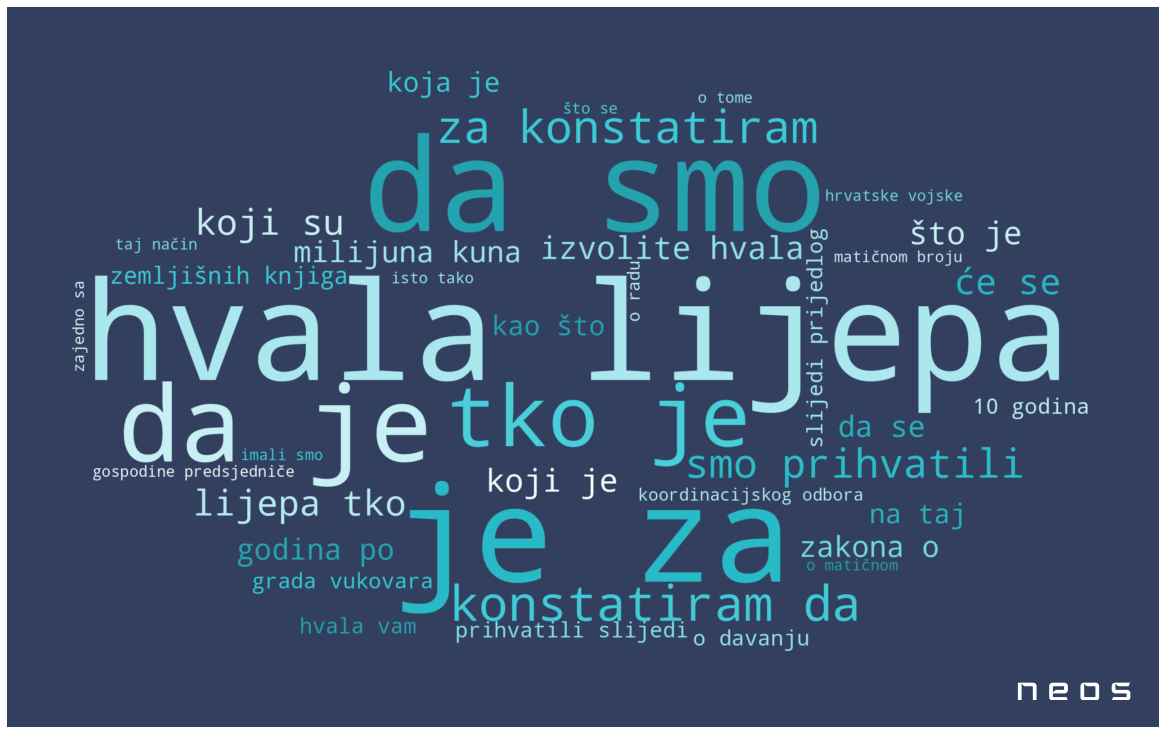

In [34]:
wordcloud_plot(wordcloud)

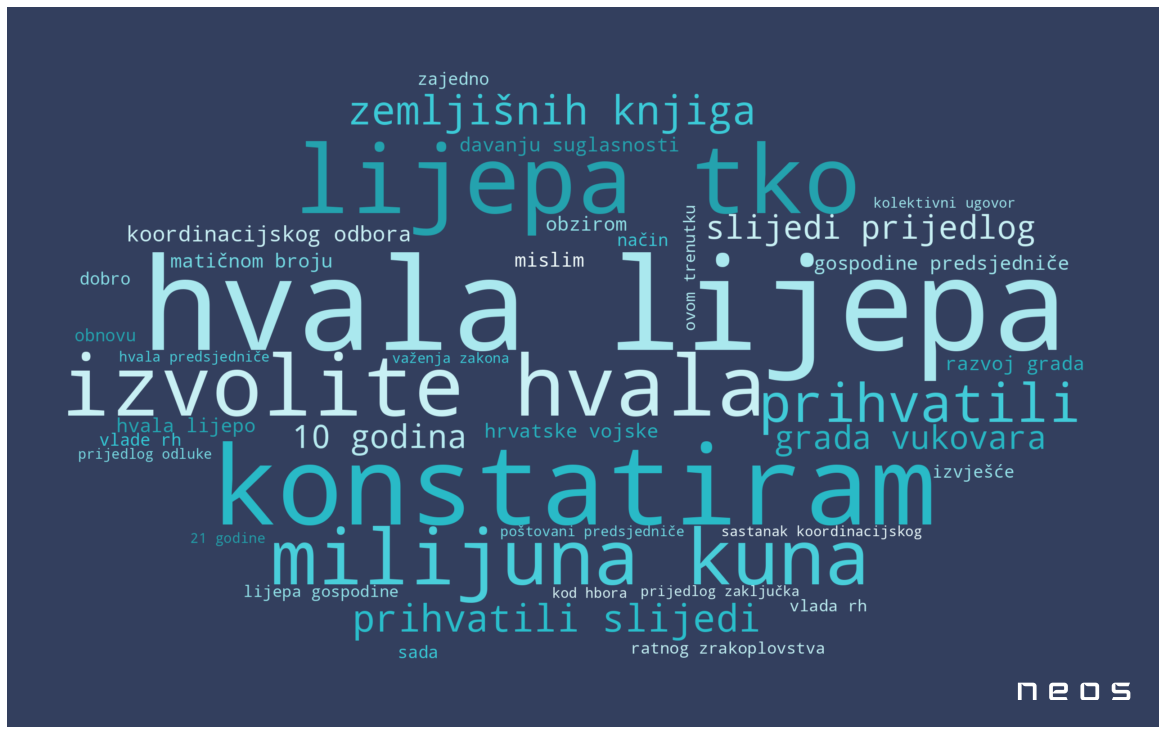

In [35]:
wordcloud_plot(wordcloud_stopwords)

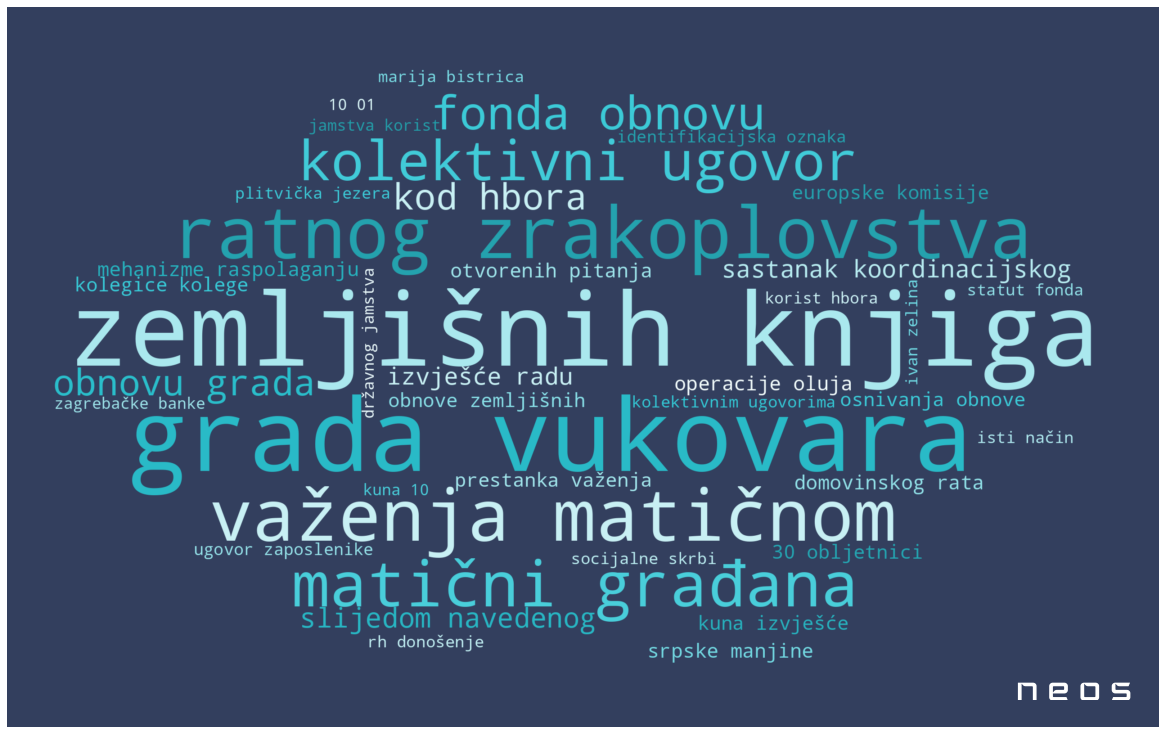

In [36]:
wordcloud_plot(wordcloud_stopwords_filtered)